In [6]:
# 📦 1. Setup
import os, glob
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# ✅ Set paths
DATA_DIR = '/content/drive/MyDrive/StateFarm/dataset/imgs/train'  # path to your dataset folder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
# 🏷️ 2. Custom Dataset
class StateFarmDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.img_paths = glob.glob(os.path.join(img_dir, '*/*.jpg'))
        self.labels = [int(p.split('/')[-2][1]) for p in self.img_paths]  # 'c0', 'c1', ...

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [9]:
# 📊 3. Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
# 🧪 4. Load Dataset
full_dataset = StateFarmDataset(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
# 🧠 5. Model Setup (ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # 10 driver classes
model = model.to(device)


In [21]:
# ⚙️ 6. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        total, correct, running_loss = 0, 0, 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix(loss=running_loss / (total / inputs.size(0)), acc=correct / total)

        val_acc = evaluate(model)
        print(f"\nEpoch {epoch+1} Summary | Train Acc: {correct/total:.4f} | Val Acc: {val_acc:.4f}\n")


In [23]:
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [24]:
# 🔍 9. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [25]:
# 🎬 10. Run Training
train_model(model, epochs=5)

Validating: 100%|██████████| 71/71 [01:26<00:00,  1.23s/it]



Epoch 1 Summary | Train Acc: 0.7702 | Val Acc: 0.8691



Validating: 100%|██████████| 71/71 [00:28<00:00,  2.46it/s]



Epoch 2 Summary | Train Acc: 0.8841 | Val Acc: 0.8974



Validating: 100%|██████████| 71/71 [00:30<00:00,  2.37it/s]



Epoch 3 Summary | Train Acc: 0.9078 | Val Acc: 0.9093



Validating: 100%|██████████| 71/71 [00:28<00:00,  2.52it/s]



Epoch 4 Summary | Train Acc: 0.9183 | Val Acc: 0.9226



Validating: 100%|██████████| 71/71 [00:28<00:00,  2.45it/s]


Epoch 5 Summary | Train Acc: 0.9237 | Val Acc: 0.9324



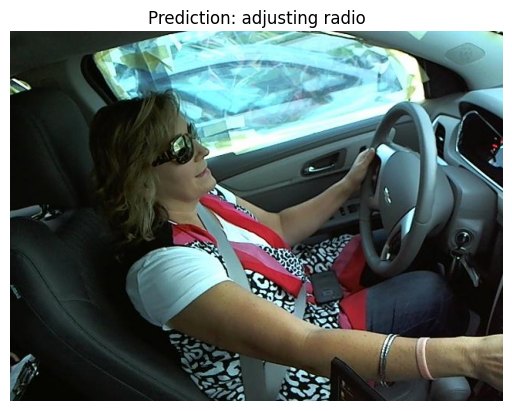

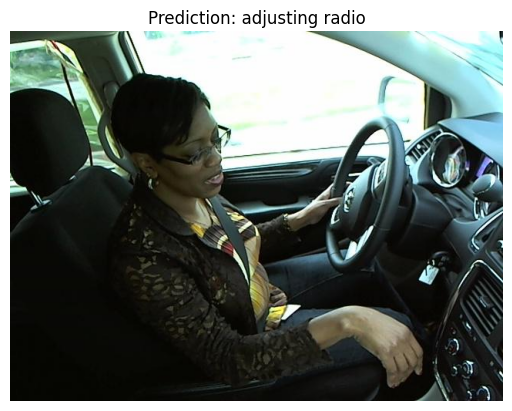

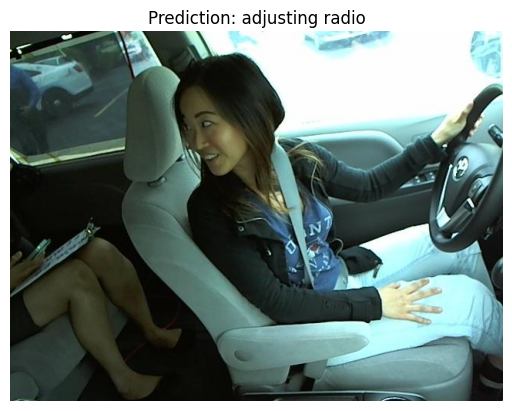

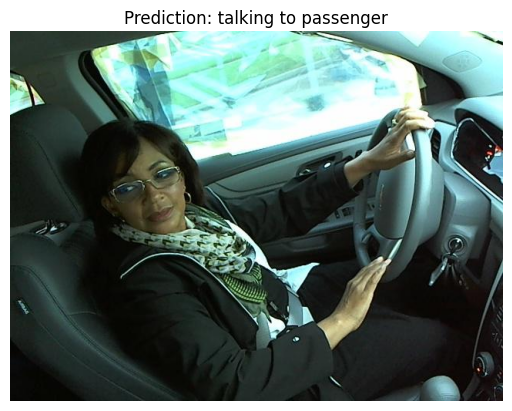

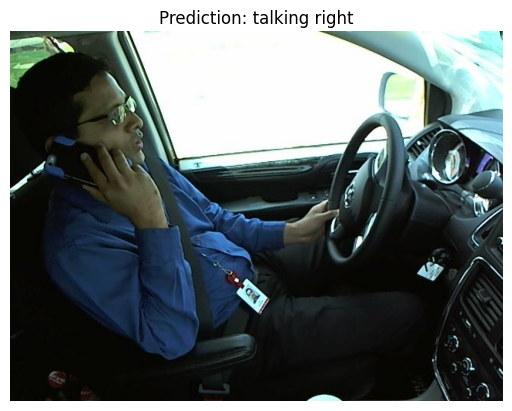

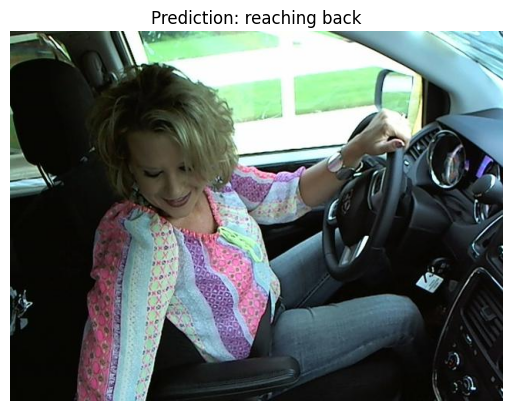

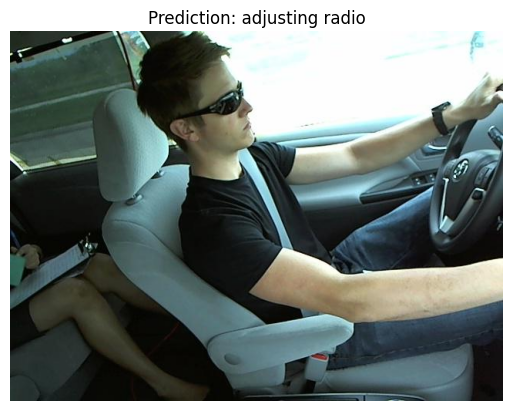

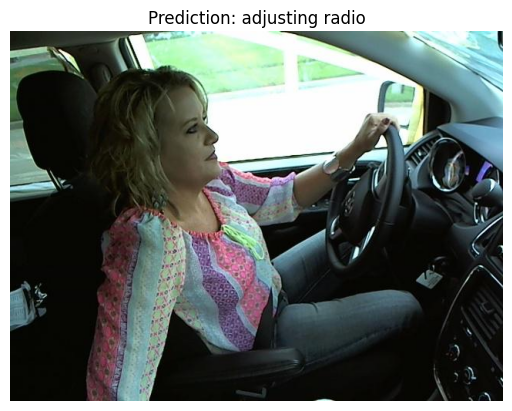

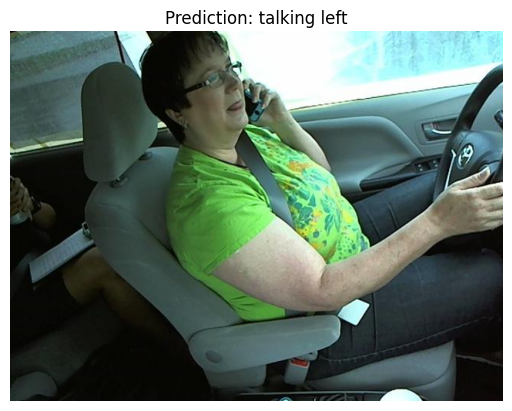

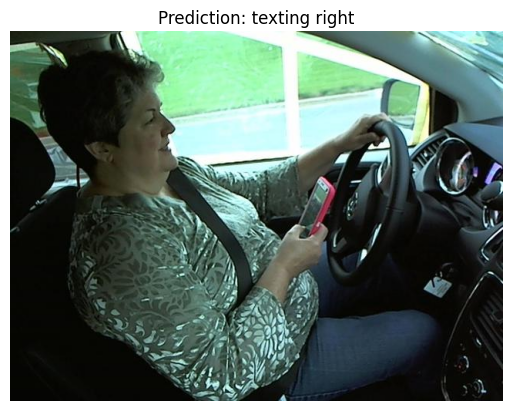

In [31]:
import os
from PIL import Image
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import random

# 🔧 Setup paths
TEST_DIR = "/content/drive/MyDrive/StateFarm/dataset/imgs/test/"
model.eval()

# 🔠 Class names
class_names = [
    'safe driving', 'texting right', 'talking right',
    'texting left', 'talking left', 'adjusting radio',
    'drinking', 'reaching back', 'hair/makeup', 'talking to passenger'
]

# 🔁 Transform (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 🔍 Run inference on a few test images
# 🎯 Pick 10 random test images
all_test_images = os.listdir(TEST_DIR)
random_images = random.sample(all_test_images, 10)

for img_name in random_images:
    img_path = os.path.join(TEST_DIR, img_name)
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, 1).item()

    # 🖼️ Show image and prediction
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred]}")
    plt.axis("off")
    plt.show()
